In [28]:
import pandas as pd
from datetime import datetime, date, timedelta
from requests import post
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.insert(1, '../src/')
from basebot import BaseBot

In [3]:
bot = BaseBot("testbot")

df = bot.getData(ticker = "IWDA.AS", start_date = datetime(2010,1,1), technical_indicators=["all"])
df = bot.getTrend(df)
df.head()

,ticker,open,high,low,close,volume,adj_close,volume_adi,volume_obv,volume_cmf,...,momentum_kama,others_dr,others_dlr,others_cr,SMA_3,SMA_10,SMA_50,SMA_100,SMA_200,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-12,IWDA.AS,42.455002,42.674999,42.455002,42.575001,53831,42.575001,4893.896985,53831.0,0.090912,...,42.575001,-25.658017,0.433580,0.434522,42.725,42.7965,44.072,None,45.01955,1.0
2017-09-13,IWDA.AS,42.540001,42.759998,42.445000,42.759998,73915,42.759998,78808.896985,127746.0,0.616919,...,42.649766,0.434522,0.433580,0.434522,42.725,42.7965,44.072,None,45.01955,1.0
2017-09-14,IWDA.AS,42.730000,42.860001,42.689999,42.840000,19521,42.840000,93736.668981,147267.0,0.636508,...,42.724116,0.187095,0.186920,0.622430,42.725,42.7965,44.072,None,45.01955,1.0
2017-09-15,IWDA.AS,42.674999,42.689999,42.470001,42.575001,25357,42.575001,92584.257942,121910.0,0.536335,...,42.662290,-0.618579,-0.620500,0.364061,42.725,42.7965,44.072,None,45.01955,1.0
2017-09-18,IWDA.AS,42.779999,42.860001,42.669998,42.730000,44301,42.730000,76263.117764,166211.0,0.351564,...,42.689158,0.364061,0.363399,0.364061,42.715,42.7965,44.072,None,45.01955,1.0


In [4]:
df["signal"].value_counts()

 1.0    862
-1.0    435
Name: signal, dtype: int64

-1 represents sell (downtrend), 1 buy (uptrend), 0 is not yet decided

## simulate best possible scenario

(following signal)

<AxesSubplot:xlabel='timestamp'>

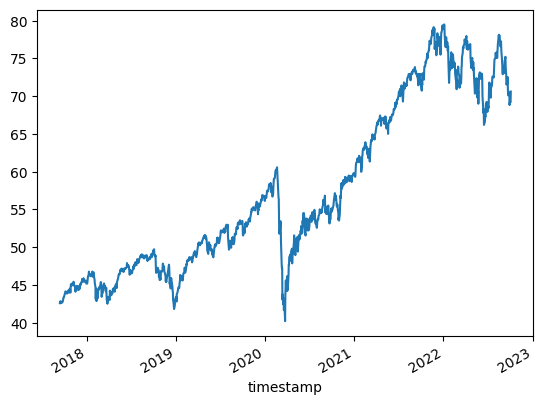

In [5]:
df["adj_close"].plot()

In [7]:
## calculate timespan
days = (df.index[-1] - df.index[0]).days
print("index takes %d days" % days)

index takes 1848 days


In [9]:
## baseline
startMoney = 10000
COMMISSION = 0.00025
nrStocks = startMoney / df.iloc[0]["adj_close"]
print("you would have bought {} stocks".format(nrStocks))
baselineWin = df.iloc[-1]["adj_close"] * nrStocks - startMoney
print("just holding would have given you %.2f$" % baselineWin)
baselineWinPerMonth = baselineWin / days * 30
print("or %.2f$ per month" % baselineWinPerMonth)

you would have bought 234.87961998358358 stocks
just holding would have given you 6582.50$
or 106.86$ per month


following the signal would have given you 24914.74$
or 404.46$ per month


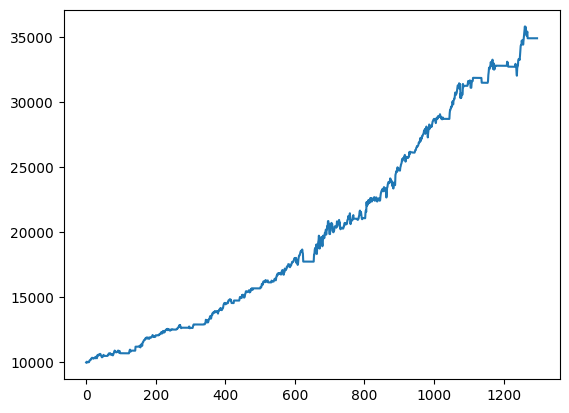

In [12]:
## next check if we follow signal what the best scenario would have been
money = startMoney
nrStocks = 0
bestPortfolio = []
for i in range(len(df)):
    if df.iloc[i]["signal"] == 1 and money > 0 and nrStocks == 0:
        amount = money / df.iloc[i]["adj_close"] * .99
        cost = amount * df.iloc[i]["adj_close"] * (1 + COMMISSION)
        money -= cost
        nrStocks += amount
    elif df.iloc[i]["signal"] == -1 and nrStocks > 0:
        money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
        nrStocks = 0
    bestPortfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
# last day sell nrStocks
money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
nrStocks = 0

win = money - startMoney
print("following the signal would have given you %.2f$" % win)
winPerMonth = win / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestPortfolio)

## find correlations

In [13]:
df.corr()["signal"]

open      -0.012703
high      -0.017628
low       -0.002791
close     -0.007943
volume    -0.189934
             ...   
SMA_3     -0.018456
SMA_10    -0.050470
SMA_50    -0.134352
SMA_200   -0.155830
signal     1.000000
Name: signal, Length: 97, dtype: float64

In [31]:
## try to get some observations with decision tree
from sklearn import tree
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(  df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0), df["signal"], test_size=0.2)
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)
scr = clf.score(x_test, y_test)
print("decision tree scores: ", scr)
pred = clf.predict(df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0))
# tree.plot_tree(clf)

decision tree scores:  0.8653846153846154


In [32]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,
                        feature_names=x_train.columns,  
                        class_names=["sell", "buy"],
                        filled=True, rounded=True,
                        special_characters=True) 
graph = graphviz.Source(dot_data) 
# graph 

## simulate one run with training data

the decision tree with lookback 0 would have given you 19227.17$
or +37.98% per year
or 312.13$ per month


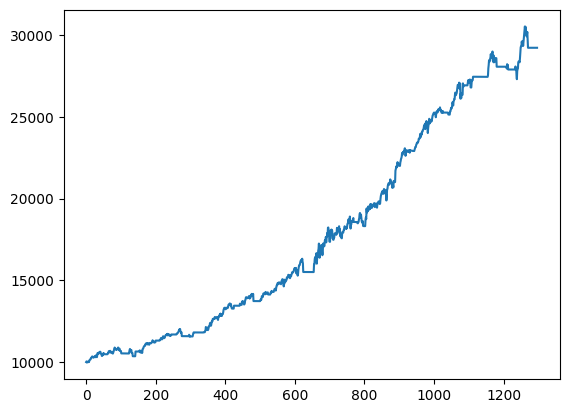

In [37]:



bestLookback = -1
bestLookbackWin = -9999
bestLookbackPortfolio = []
for lookback in [0]: # range(0, 10):
    money = startMoney
    nrStocks = 0
    portfolio = []
    for i in range(lookback, len(df)):
        # prednow = np.median(pred[i-lookback:i])
        prednow = pred[i]
        if prednow == 1 and nrStocks == 0 and money > 10:
            # buy
            howmany = money / df.iloc[i]["adj_close"] * .99
            cost = howmany * df.iloc[i]["adj_close"] * (1 + COMMISSION)
            money -= cost
            nrStocks += howmany
        elif prednow == -1 and nrStocks > 0:
            money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
        portfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
    # last day sell
    money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
    win = money - startMoney
    if win > bestLookbackWin:
        bestLookback = lookback
        bestLookbackWin = win
        bestLookbackPortfolio = portfolio

print("the decision tree with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
winPct = bestLookbackWin / startMoney * 100
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestLookbackPortfolio)
# lookback of 1
# the decision tree would have given you 19937.82$
# or 323.67$ per month

## try the same with xgb

In [41]:
# xgb doesnt like -1
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

In [47]:
import xgboost as xgb
from sklearn import metrics


clf = xgb.XGBClassifier(n_jobs = -1)
clf.fit(x_train, y_train)
# print(clf)
predicted_y = clf.predict(x_test)


In [48]:
print(metrics.classification_report(y_test, predicted_y))
print(metrics.confusion_matrix(y_test, predicted_y))



              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83        87
         1.0       0.91      0.94      0.92       173

    accuracy                           0.89       260
   macro avg       0.88      0.87      0.88       260
weighted avg       0.89      0.89      0.89       260

[[ 70  17]
 [ 11 162]]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

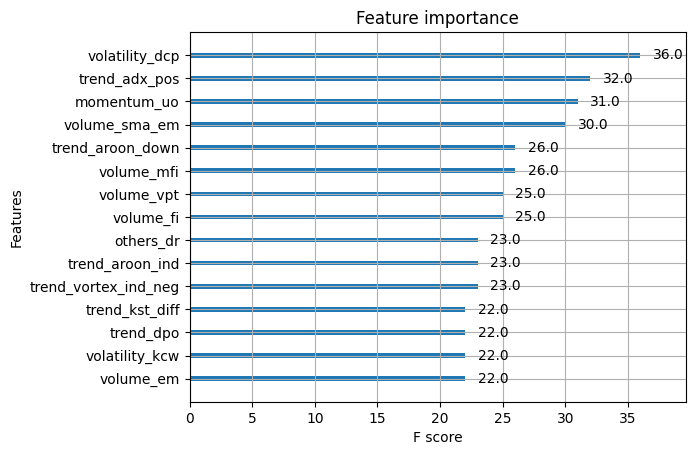

In [51]:
xgb.plot_importance(clf, max_num_features=15)

In [52]:
preds = clf.predict(df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0))

/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


the decision tree with lookback 3 would have given you 3497.44$
or +6.91% per year
or 56.78$ per month


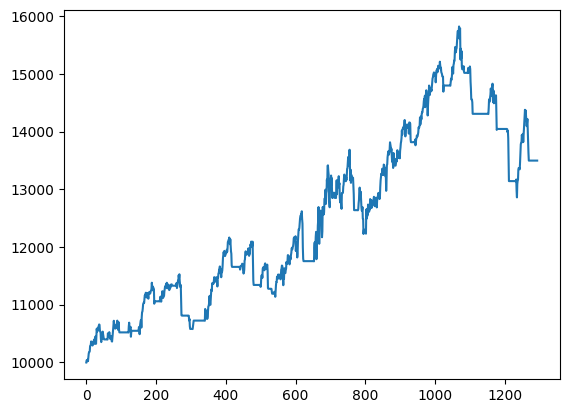

In [54]:
## do the same dance as with tree


bestLookback = -1
bestLookbackWin = -9999
bestLookbackPortfolio = []
for lookback in range(0, 10):
    money = startMoney
    nrStocks = 0
    portfolio = []
    for i in range(lookback, len(df)):
        prednow = np.median(pred[i-lookback:i])
        # prednow = preds[i]
        if prednow == 1 and nrStocks == 0 and money > 10:
            # buy
            howmany = money / df.iloc[i]["adj_close"] * .99
            cost = howmany * df.iloc[i]["adj_close"] * (1 + COMMISSION)
            money -= cost
            nrStocks += howmany
        elif prednow == -1 and nrStocks > 0:
            money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
        portfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
    # last day sell
    money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
    win = money - startMoney
    if win > bestLookbackWin:
        bestLookback = lookback
        bestLookbackWin = win
        bestLookbackPortfolio = portfolio

print("the decision tree with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
winPct = bestLookbackWin / startMoney * 100
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestLookbackPortfolio)
## tree
# the decision tree with lookback 0 would have given you 19227.17$
# or +37.98% per year
# or 312.13$ per month
## XGB - actually not too nice
# the xgb with lookback 3 would have given you 3497.44$
# or +6.91% per year
# or 56.78$ per month


## lgbm classifer